In [1]:
import yolo
from yolo import YOLO

import torch
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from sklearn import metrics


# Use GPU if available
device = "0" if torch.cuda.is_available() else "cpu"
if device == "0":
    torch.cuda.set_device(0) # Set to your desired GPU number

from plotting_utils import plot_grid_search_losses, plot_map_hist, plot_map_hist_s, plot_multiplearch_losses

module_path = os.path.abspath(os.path.join('..'))
print(module_path)

if module_path not in sys.path:
    sys.path.append(module_path)

#import data_preprocessing.visualization_utils as visutils
from model.constants import DATA_PATH, DATASETS_MAPPING, MODELS_PATH, NB_EPOCHS, BATCH_SIZE, PATIENCE, OPTIMIZER, TRAINING_IOU_THRESHOLD, CONF_THRESHOLD, NB_CONF_THRESHOLDS, NMS_IOU_THRESHOLD


/vast/palmer/home.grace/eec42/BirdDetector/src


## **Gain grid searches**
## on {source:Penguins, target:Palmyra}

p= 0.75
p= 1.0
p= 1.5
p= 2
p= 3
p= 5
p= 10
['0.75', '1.0', '1.5', '2', '3', '5', '10']
p= 0.5
p= 0.75
p= 1.0
p= 1.5
p= 2
p= 3
p= 5
p= 10
['0.5', '0.75', '1.0', '1.5', '2', '3', '5', '10']
p= 0.5
p= 0.75
p= 1.0
p= 1.5
p= 2
p= 3
p= 5
p= 10
['0.5', '0.75', '1.0', '1.5', '2', '3', '5', '10']


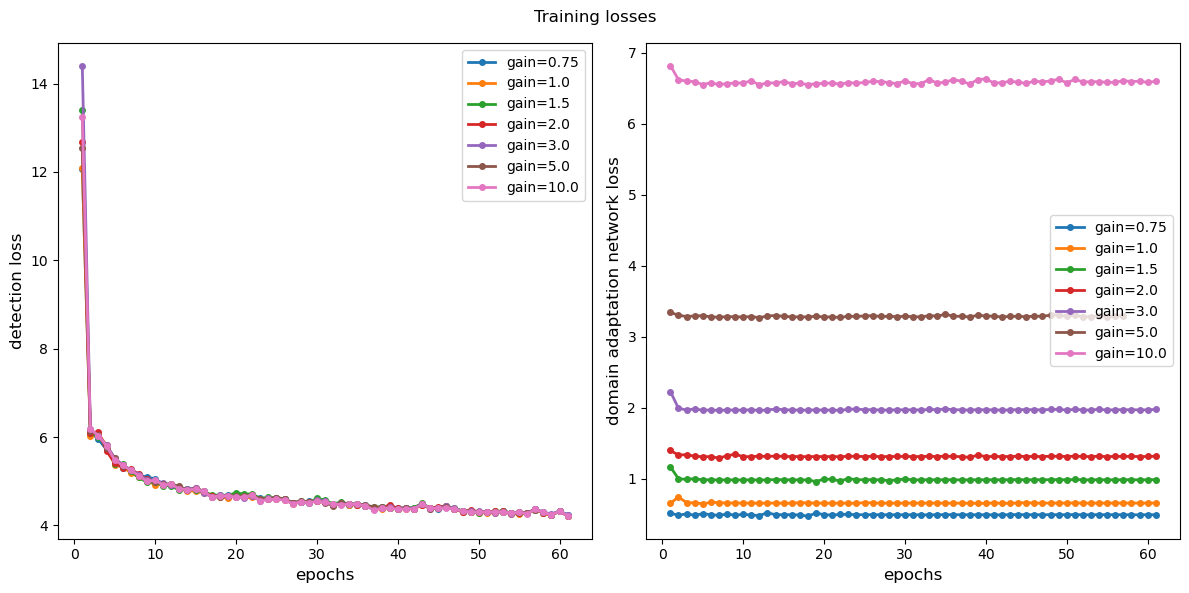

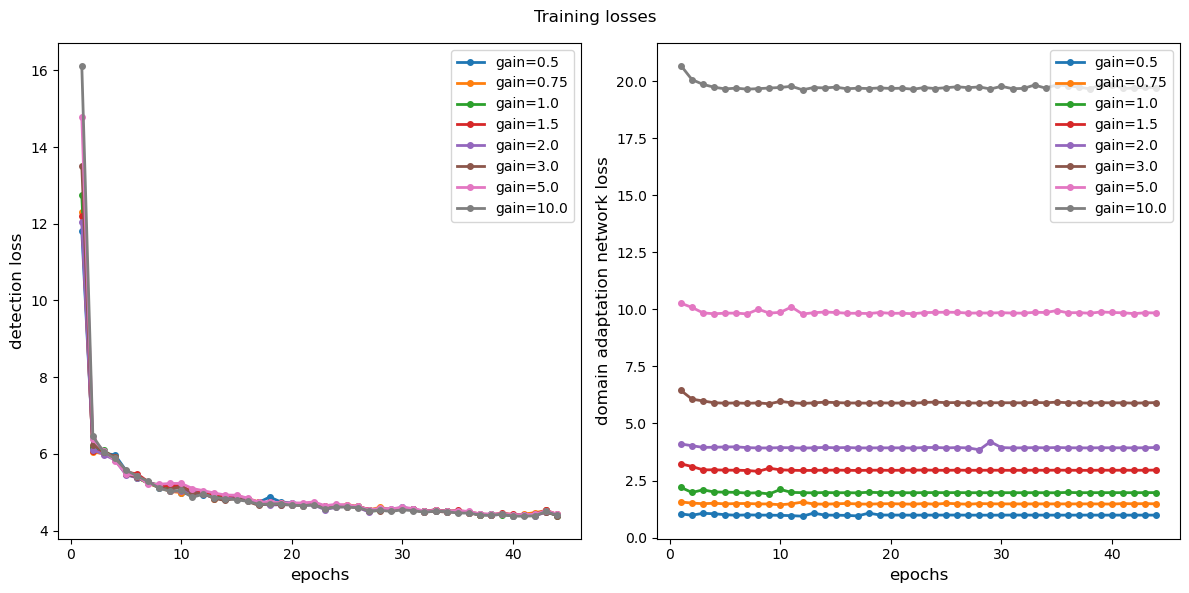

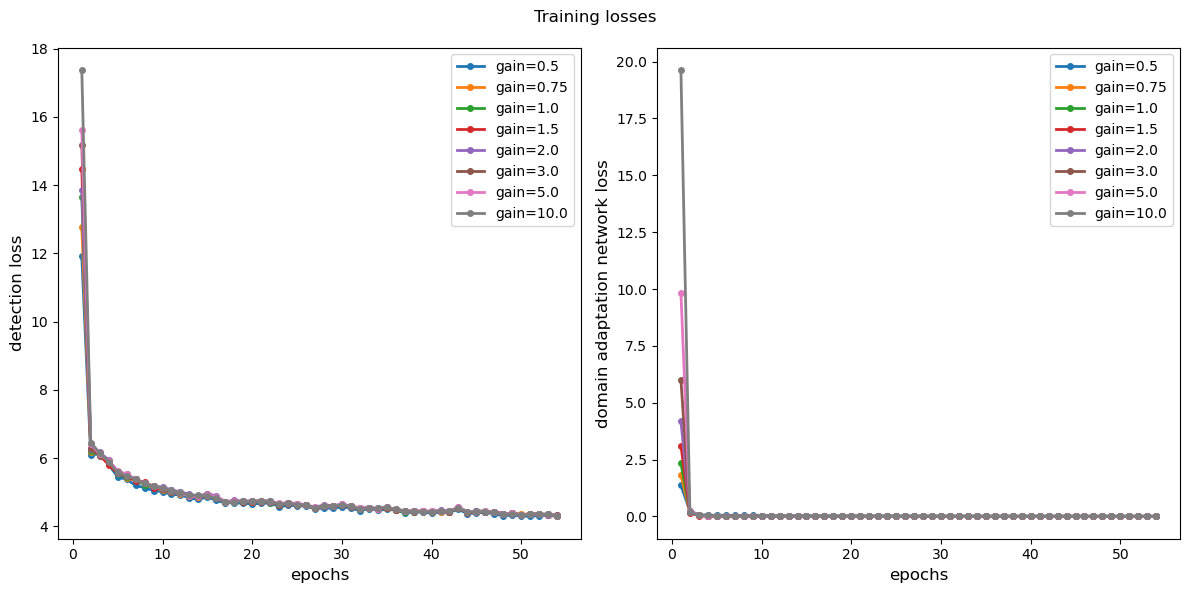

In [2]:
maps = {'pe_palmyra_10percentbkgd': {'DAN': {'gains': ['0.75','1.0','1.5','2','3','5','10'], 
                                             'map_target': [0.74, 0.57, 0.76, 0.7, 0.49, 0.62, 0.59],
                                             'map_source': [0.92, 0.94, 0.94, 0.92, 0.93, 0.91, 0.91],
                                             'map': [0.91, 0.92, 0.93, 0.91, 0.9, 0.9, 0.89]},
                                    'multiDAN': {'gains': ['0.5','0.75','1.0','1.5','2','3','5','10'],
                                                  'map_target': [0.8, 0.65, 0.53, 0.63, 0.68, 0.6, 0.67, 0.52],
                                                  'map_source': [0.92, 0.92, 0.92, 0.94, 0.93, 0.94, 0.92, 0.91],
                                                  'map': [0.91, 0.91, 0.9, 0.92, 0.91, 0.92, 0.9, 0.88],},
                                    'featdist': {'gains': ['0.5','0.75','1.0','1.5','2','3','5','10'], 
                                                 'map_target': [0.63, 0.62, 0.66, 0.65, 0.61, 0.57, 0.7, 0.32],
                                                 'map_source': [0.9, 0.92, 0.92, 0.92, 0.92, 0.89, 0.91, 0.94],
                                                 'map': [0.89, 0.9, 0.91, 0.91, 0.9, 0.87, 0.9, 0.9],},}
        }

CSV_FILE = "results.csv"

# Predictions parameters
eps = 1e-8

DATASET_NAME = list(maps.keys())[0]
SUBDATASETS = DATASETS_MAPPING[DATASET_NAME]['datasets']
MODEL_NAME_PREFIX_ = DATASET_NAME + '_'
models_folder = '/home/eec42/BirdDetector/runs/pe_palm_gain_search/'

for task in maps[DATASET_NAME].keys():

    MODEL_NAME_PREFIX = task + "_" + MODEL_NAME_PREFIX_
    GAINs = maps[DATASET_NAME][task]['gains']
    plot_grid_search_losses(task, models_folder, MODEL_NAME_PREFIX, "gain", GAINs)
    map = maps[DATASET_NAME][task]['map']
    map_target = maps[DATASET_NAME][task]['map_target']
    map_source = maps[DATASET_NAME][task]['map_source']
    plot_map_hist(models_folder, MODEL_NAME_PREFIX, 'gain', GAINs, map)
    plot_map_hist_s(models_folder, MODEL_NAME_PREFIX, 'gain', GAINs, map, map_source, map_target)



## **Original YOLO models**
### All datasets

{'source': ['global_birds_pfeifer', 'global_birds_palmyra', 'global_birds_mckellar', 'global_birds_penguins', 'global_birds_poland', 'uav_thermal_waterfowl']}


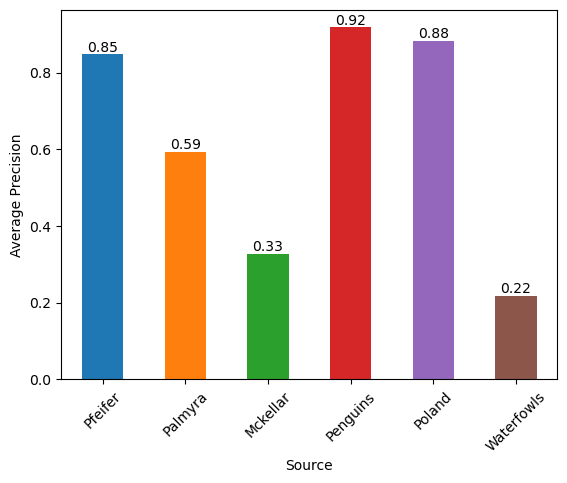

In [14]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect/'

# First model - Penguins+Pfeifer
DATASET = 'all_datasets_minusHayesTerns_10percentbkgd_onall'  #'all_datasets_10percent_background' # 'alldatasets_allbckgd'  #'alldatasets_minus_hayes'
SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
dataset_names = {'global_birds_pfeifer': "Pfeifer", 'global_birds_palmyra': "Palmyra", 'global_birds_mckellar': "Mckellar", 'global_birds_penguins': "Penguins", 'global_birds_poland': "Poland", 'uav_thermal_waterfowl': "Waterfowls"} #, 'terns_africa': "Terns", 'hayes_albatross': "Hayes"}

#MODEL_NAME = 'YOLO_' + DATASET #+ '_onall_optimauto_nosingleclass'
MODEL_NAME = 'YOLO_all_datasets_minusHayesTerns_10percentbkgd_onall_oldconfig_semi_test2'
model_dir = os.path.join(models_folder, MODEL_NAME)
results = os.path.join(model_dir, 'eval_iou0.3', EVAL_FILE)
with open(results) as json_data:
    data = json.load(json_data)
    json_data.close()

conf_thresholds = data['confidence_thresholds']
FN = np.array(data['results_metrics']['FN'])
FP = np.array(data['results_metrics']['FP'])
TN = np.array(data['results_metrics']['TN'])
TP = np.array(data['results_metrics']['TP'])
print(data['datasets'])

global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
best_f1 = np.max(global_f1)
best_f1_conf = conf_thresholds[np.argmax(global_f1)]
# Compute Average Precision & plot PR curves
global_AP = metrics.auc(y=global_precision, x=global_recall)

APs = []

for dataset_i, dataset in enumerate(SUBDATASETS):

    precision = TP[dataset_i, :] / (TP[dataset_i, :] + FP[dataset_i, :] + eps)
    recall = TP[dataset_i, :] / (TP[dataset_i, :] + FN[dataset_i, :] + eps)
                               
    f1 = 2*(precision*recall)/(precision+recall+eps)
    best_f1 = np.max(global_f1)
    best_f1_conf = conf_thresholds[np.argmax(global_f1)]

    # Compute Average Precision & plot PR curves
    AP = metrics.auc(y=precision, x=recall)
    APs.append(AP)
    
paired = mpl.colormaps['tab10'].resampled(10)
#fig, ax = plt.subplots(1, 1, figsize=(7, 6), tight_layout=True)
df_map = pd.DataFrame({"dataset": dataset_names.values(), "AP": APs})
ax = df_map.plot.bar(x="dataset", y="AP", rot=45, legend=False, color=[paired(0), paired(0.1), paired(0.2), paired(0.3), paired(0.4), paired(0.5), paired(0.6), paired(0.7)])
ax.bar_label(ax.containers[0], fmt="{:0.2f}")
ax.set_xlabel("Source")
ax.set_ylabel("Average Precision")
fname = os.path.join(models_folder, MODEL_NAME + 'iou0.3_sources_AP.png')
plt.savefig(fname, dpi=200)
plt.show()




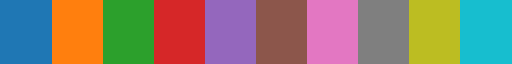

In [4]:
#colors = [plt.colors.to_hex(cmap(i)) for i in range(N)]
plt.colormaps.get_cmap('tab10')
#print(cmap[0])

### IOU NMS threshold grid search

{'source': ['global_birds_pfeifer', 'global_birds_palmyra', 'global_birds_mckellar', 'global_birds_penguins', 'global_birds_poland', 'uav_thermal_waterfowl']}
{'source': ['global_birds_pfeifer', 'global_birds_palmyra', 'global_birds_mckellar', 'global_birds_penguins', 'global_birds_poland', 'uav_thermal_waterfowl']}
{'source': ['global_birds_pfeifer', 'global_birds_palmyra', 'global_birds_mckellar', 'global_birds_penguins', 'global_birds_poland', 'uav_thermal_waterfowl']}
{'source': ['global_birds_pfeifer', 'global_birds_palmyra', 'global_birds_mckellar', 'global_birds_penguins', 'global_birds_poland', 'uav_thermal_waterfowl']}
{'source': ['global_birds_pfeifer', 'global_birds_palmyra', 'global_birds_mckellar', 'global_birds_penguins', 'global_birds_poland', 'uav_thermal_waterfowl']}
{'source': ['global_birds_pfeifer', 'global_birds_palmyra', 'global_birds_mckellar', 'global_birds_penguins', 'global_birds_poland', 'uav_thermal_waterfowl']}
{'source': ['global_birds_pfeifer', 'global_bi

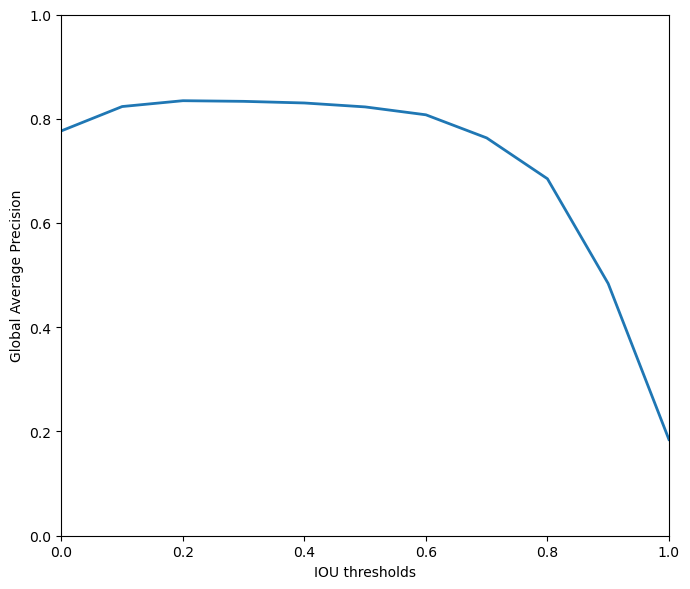

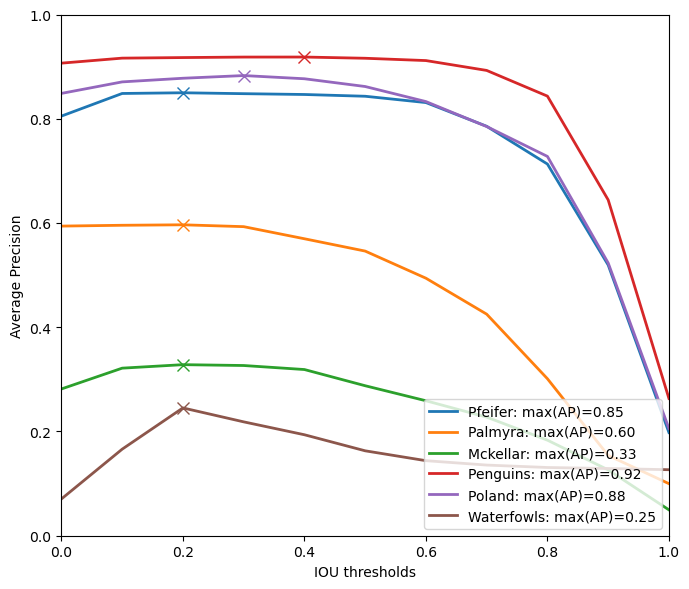

In [9]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect/'

# First model - Penguins+Pfeifer
DATASET = 'all_datasets_minusHayesTerns_10percentbkgd_onall'  #'alldatasets_minus_hayes'
SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
dataset_names = {'global_birds_pfeifer': "Pfeifer", 'global_birds_palmyra': "Palmyra", 'global_birds_mckellar': "Mckellar", 'global_birds_penguins': "Penguins", 'global_birds_poland': "Poland", 'uav_thermal_waterfowl': "Waterfowls", 'terns_africa': "Terns", 'hayes_albatross': "Hayes"}


IOUs = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
global_APs = []
dataset_APs = []
#MODEL_NAME = 'YOLO_' + DATASET
MODEL_NAME = 'YOLO_all_datasets_minusHayesTerns_10percentbkgd_onall_oldconfig_semi_test2'
model_dir = os.path.join(models_folder, MODEL_NAME)

for iou in IOUs:
    results = os.path.join(model_dir, 'eval_iou' + str(iou), EVAL_FILE)
    with open(results) as json_data:
        data = json.load(json_data)
        json_data.close()

    conf_thresholds = data['confidence_thresholds']
    FN = np.array(data['results_metrics']['FN'])
    FP = np.array(data['results_metrics']['FP'])
    TN = np.array(data['results_metrics']['TN'])
    TP = np.array(data['results_metrics']['TP'])
    print(data['datasets'])

    global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
    global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
    global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
    best_f1 = np.max(global_f1)
    best_f1_conf = conf_thresholds[np.argmax(global_f1)]
    # Compute Average Precision & plot PR curves
    global_AP = metrics.auc(y=global_precision, x=global_recall)
    global_APs.append(global_AP)

    current_iou_APs = []


    for dataset_i, dataset in enumerate(SUBDATASETS):

        precision = TP[dataset_i, :] / (TP[dataset_i, :] + FP[dataset_i, :] + eps)
        recall = TP[dataset_i, :] / (TP[dataset_i, :] + FN[dataset_i, :] + eps)
                                
        f1 = 2*(precision*recall)/(precision+recall+eps)
        best_f1 = np.max(global_f1)
        best_f1_conf = conf_thresholds[np.argmax(global_f1)]

        # Compute Average Precision & plot PR curves
        AP = metrics.auc(y=precision, x=recall)
        current_iou_APs.append(AP)

    dataset_APs.append(current_iou_APs)


dataset_APs = np.array(dataset_APs)

fig, ax = plt.subplots(1, 1, figsize=(7, 6), tight_layout=True)
ax.plot(IOUs, global_APs, linewidth=2) #, label=f'Penguins-Pfeifer: AP={global_AP:.2f}')
ax.set_xlabel('IOU thresholds')
ax.set_ylabel('Global Average Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
#ax.legend(loc='upper right')
#ax.set_title('')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'AP_over_ious.jpg'), dpi=250)
plt.show()
plt.close(fig)


paired = mpl.colormaps['tab10'].resampled(10)
fig, ax = plt.subplots(1, 1, figsize=(7, 6), tight_layout=True)
for dataset_i, dataset in enumerate(SUBDATASETS):
    current_iou_APs = dataset_APs[:, dataset_i]
    best_AP = np.max(current_iou_APs)
    best_AP_iou = IOUs[np.argmax(current_iou_APs)]
    ax.plot(IOUs, current_iou_APs, linewidth=2, label=f'{dataset_names[dataset]}: max(AP)={best_AP:.2f}', color=paired(dataset_i))
    ax.plot(best_AP_iou, best_AP, 'x', linewidth=10, markersize=8)
    
ax.set_xlabel('IOU thresholds')
ax.set_ylabel('Average Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc='lower right')
#ax.set_title('')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'AP_over_ious_and_sources.jpg'), dpi=250)
plt.show()
plt.close(fig)



In [10]:
dataset_APs
np.array(dataset_APs)

array([[    0.77906,     0.71156,     0.25247,     0.91627,     0.81018,     0.57018,     0.96861,     0.39967],
       [    0.89192,      0.7158,     0.26093,     0.93628,     0.83097,     0.63766,     0.97518,     0.53628],
       [    0.89578,     0.71355,     0.27773,     0.93869,     0.83699,     0.63336,     0.97715,     0.82392],
       [    0.89193,     0.70171,      0.2784,     0.93967,     0.83415,      0.5933,     0.97701,     0.94682],
       [    0.88922,     0.66177,     0.26282,     0.94045,     0.82858,     0.52121,      0.9769,     0.95327],
       [    0.88375,     0.62681,     0.25215,     0.94037,     0.81037,     0.46525,      0.9765,     0.95311],
       [    0.84293,     0.53535,     0.21385,     0.93442,     0.70921,      0.4351,     0.97363,     0.95072]])

### Penguins-Pfeifer-Palmyra studies
#### IOU NMS threshold with {Penguins-Palmyra}

{'source': ['global_birds_penguins', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_palmyra']}


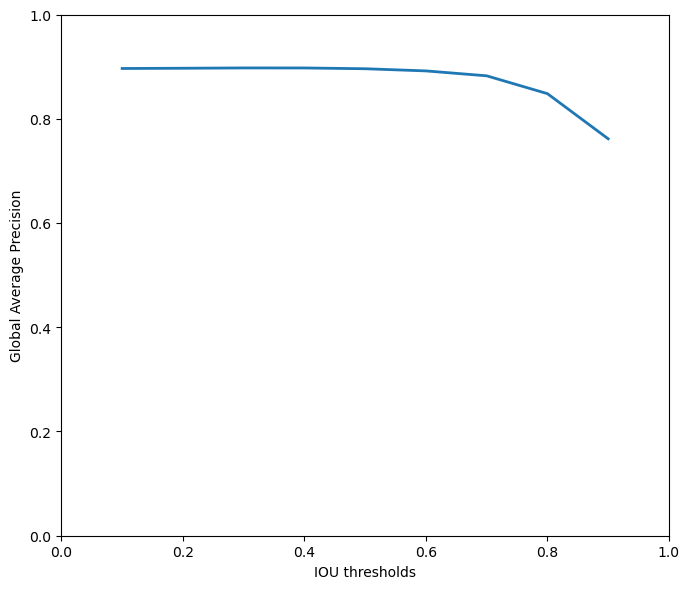

0.061224489795918366
0.02040816326530612


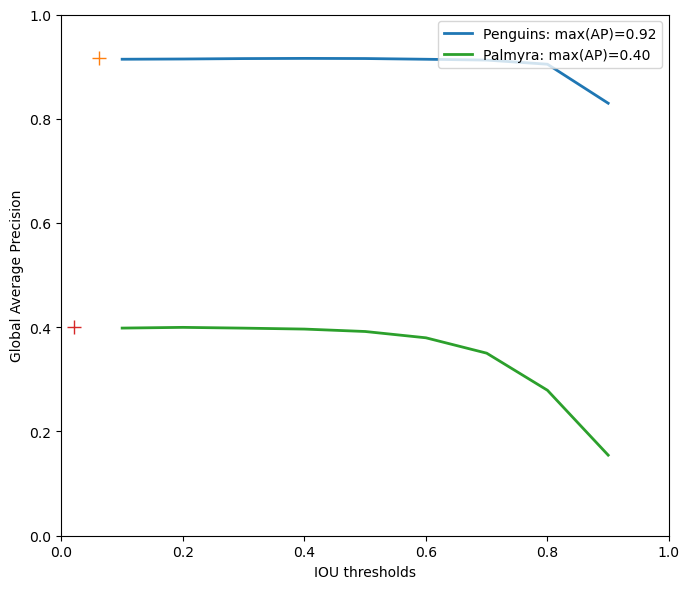

In [20]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect/'

# First model - Penguins+Pfeifer
DATASET = 'pe_palmyra_10percentbkgd'  #'alldatasets_minus_hayes'
SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
dataset_names = {'global_birds_pfeifer': "Pfeifer", 'global_birds_palmyra': "Palmyra", 'global_birds_mckellar': "Mckellar", 'global_birds_penguins': "Penguins", 'global_birds_poland': "Poland", 'uav_thermal_waterfowl': "Waterfowls", 'terns_africa': "Terns", 'hayes_albatross': "Hayes"}


IOUs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
global_APs = []
dataset_APs = []
MODEL_NAME = 'YOLO_' + DATASET
model_dir = os.path.join(models_folder, MODEL_NAME)

for iou in IOUs:
    results = os.path.join(model_dir, 'eval_iou' + str(iou), EVAL_FILE)
    with open(results) as json_data:
        data = json.load(json_data)
        json_data.close()

    conf_thresholds = data['confidence_thresholds']
    FN = np.array(data['results_metrics']['FN'])
    FP = np.array(data['results_metrics']['FP'])
    TN = np.array(data['results_metrics']['TN'])
    TP = np.array(data['results_metrics']['TP'])
    print(data['datasets'])

    global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
    global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
    global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
    best_f1 = np.max(global_f1)
    best_f1_conf = conf_thresholds[np.argmax(global_f1)]
    # Compute Average Precision & plot PR curves
    global_AP = metrics.auc(y=global_precision, x=global_recall)
    global_APs.append(global_AP)

    current_iou_APs = []


    for dataset_i, dataset in enumerate(SUBDATASETS):

        precision = TP[dataset_i, :] / (TP[dataset_i, :] + FP[dataset_i, :] + eps)
        recall = TP[dataset_i, :] / (TP[dataset_i, :] + FN[dataset_i, :] + eps)
                                
        f1 = 2*(precision*recall)/(precision+recall+eps)
        best_f1 = np.max(global_f1)
        best_f1_conf = conf_thresholds[np.argmax(global_f1)]

        # Compute Average Precision & plot PR curves
        AP = metrics.auc(y=precision, x=recall)
        current_iou_APs.append(AP)

    dataset_APs.append(current_iou_APs)



fig, ax = plt.subplots(1, 1, figsize=(7, 6), tight_layout=True)
ax.plot(IOUs, global_APs, linewidth=2) #, label=f'Penguins-Pfeifer: AP={global_AP:.2f}')
ax.set_xlabel('IOU thresholds')
ax.set_ylabel('Global Average Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
#ax.legend(loc='upper right')
#ax.set_title('')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'AP_over_ious.jpg'), dpi=250)
plt.show()
plt.close(fig)


fig, ax = plt.subplots(1, 1, figsize=(7, 6), tight_layout=True)
for dataset_i, dataset in enumerate(SUBDATASETS):
    current_dataset_AP = [row[dataset_i] for row in dataset_APs]
    best_AP = np.max(current_dataset_AP)
    best_AP_iou = conf_thresholds[np.argmax(current_dataset_AP)]
    print(best_AP_iou)
    ax.plot(IOUs, current_dataset_AP, linewidth=2, label=f'{dataset_names[dataset]}: max(AP)={best_AP:.2f}')
    ax.plot(best_AP_iou, best_AP, '+', linewidth=10, markersize=10)
    
ax.set_xlabel('IOU thresholds')
ax.set_ylabel('Global Average Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
#ax.set_title('')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'AP_over_ious_and_sources.jpg'), dpi=250)
plt.show()
plt.close(fig)



### AP curves

{'source': ['global_birds_penguins', 'global_birds_pfeifer']}
{'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_palmyra']}


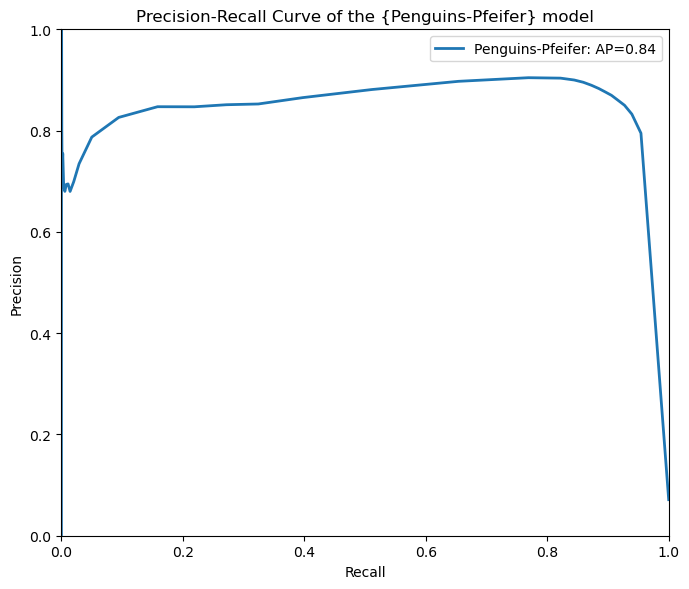

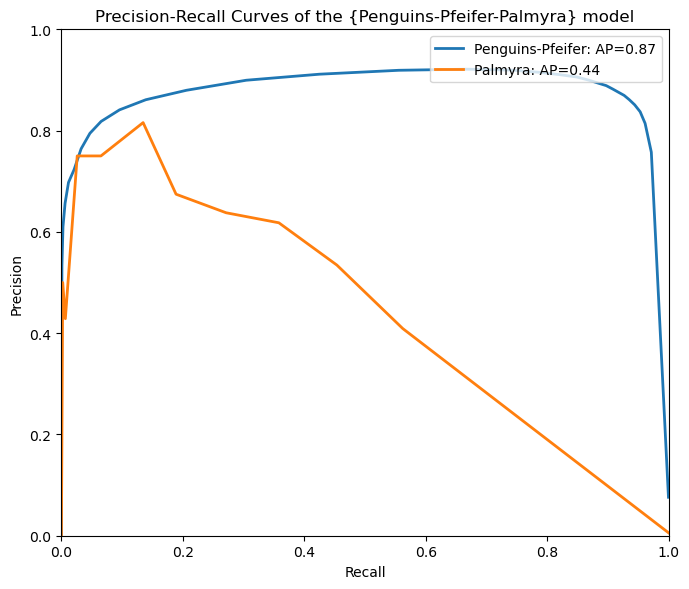

In [20]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect/'

# First model - Penguins+Pfeifer
DATASET = 'pepf_10percent_background'
SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
MODEL_NAME = 'YOLO_' + DATASET
model_dir = os.path.join(models_folder, MODEL_NAME)
results = os.path.join(model_dir, 'eval', EVAL_FILE)
with open(results) as json_data:
    data = json.load(json_data)
    json_data.close()

conf_thresholds = data['confidence_thresholds']
FN = np.array(data['results_metrics']['FN'])
FP = np.array(data['results_metrics']['FP'])
TN = np.array(data['results_metrics']['TN'])
TP = np.array(data['results_metrics']['TP'])
print(data['datasets'])

global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)


# Second model - Penguins+Pfeifer+Palmyra
DATASET = 'pepf_palmyra_10percentbkgd'
SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
MODEL_NAME = 'YOLO_' + DATASET
model_dir = os.path.join(models_folder, MODEL_NAME)
results = os.path.join(model_dir, 'eval', EVAL_FILE)
with open(results) as json_data:
    data = json.load(json_data)
    json_data.close()

conf_thresholds = data['confidence_thresholds']
FN = np.array(data['results_metrics']['FN'])
FP = np.array(data['results_metrics']['FP'])
TN = np.array(data['results_metrics']['TN'])
TP = np.array(data['results_metrics']['TP'])
print(data['datasets'])

source_datasets_indices = [0, 1]
target_datasets_indices = [2]

source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)

global_precision_2 = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
global_recall_2 = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
                                     
source_f1 = 2*(source_precision*source_recall)/(source_precision+source_recall+eps)
target_f1 = 2*(target_precision*target_recall)/(target_precision+target_recall+eps)
global_f1_2 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
best_f1_2 = np.max(global_f1)
best_f1_conf_2 = conf_thresholds[np.argmax(global_f1)]


# Compute Average Precision & plot PR curves
global_AP = metrics.auc(y=global_precision, x=global_recall)
source_AP = metrics.auc(y=source_precision, x=source_recall)
target_AP = metrics.auc(y=target_precision, x=target_recall)

fig, ax = plt.subplots(1, 1, figsize=(7, 6), tight_layout=True)
ax.plot(global_recall, global_precision, linewidth=2, label=f'Penguins-Pfeifer: AP={global_AP:.2f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
ax.set_title('Precision-Recall Curve of the {Penguins-Pfeifer} model')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'PRcurve_Global.jpg'), dpi=250)
plt.show()
plt.close(fig)


fig, ax = plt.subplots(1, 1, figsize=(7, 6), tight_layout=True)
ax.plot(source_recall, source_precision, linewidth=2, label=f'Penguins-Pfeifer: AP={source_AP:.2f}')  # plot(recall, precision)
ax.plot(target_recall, target_precision, linewidth=2, label=f'Palmyra: AP={target_AP:.2f}')  # plot(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
ax.set_title('Precision-Recall Curves of the {Penguins-Pfeifer-Palmyra} model')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'PRcurve_SourceTarget.jpg'), dpi=250)
plt.show()
plt.close(fig)


In [ ]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect/'

# First model - Penguins+Pfeifer
DATASET = 'pe_10percent_background'
SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
MODEL_NAME = 'YOLO_' + DATASET
model_dir = os.path.join(models_folder, MODEL_NAME)
results = os.path.join(model_dir, 'eval', EVAL_FILE)
with open(results) as json_data:
    data = json.load(json_data)
    json_data.close()

conf_thresholds = data['confidence_thresholds']
FN = np.array(data['results_metrics']['FN'])
FP = np.array(data['results_metrics']['FP'])
TN = np.array(data['results_metrics']['TN'])
TP = np.array(data['results_metrics']['TP'])
print(data['datasets'])

global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
best_f1 = np.max(global_f1)
best_f1_conf = conf_thresholds[np.argmax(global_f1)]


# Second model - Penguins+Pfeifer+Palmyra
DATASET = 'pe_palmyra_10percentbkgd'
SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
MODEL_NAME = 'YOLO_' + DATASET
model_dir = os.path.join(models_folder, MODEL_NAME)
results = os.path.join(model_dir, 'eval', EVAL_FILE)
with open(results) as json_data:
    data = json.load(json_data)
    json_data.close()

conf_thresholds = data['confidence_thresholds']
FN = np.array(data['results_metrics']['FN'])
FP = np.array(data['results_metrics']['FP'])
TN = np.array(data['results_metrics']['TN'])
TP = np.array(data['results_metrics']['TP'])
print(data['datasets'])

source_datasets_indices = [0, 1]
target_datasets_indices = [2]

source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)

global_precision_2 = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
global_recall_2 = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
                                     
source_f1 = 2*(source_precision*source_recall)/(source_precision+source_recall+eps)
target_f1 = 2*(target_precision*target_recall)/(target_precision+target_recall+eps)
global_f1_2 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
best_f1_2 = np.max(global_f1)
best_f1_conf_2 = conf_thresholds[np.argmax(global_f1)]


# Compute Average Precision & plot PR curves
global_AP = metrics.auc(y=global_precision, x=global_recall)
source_AP = metrics.auc(y=source_precision, x=source_recall)
target_AP = metrics.auc(y=target_precision, x=target_recall)

fig, ax = plt.subplots(1, 1, figsize=(7, 6), tight_layout=True)
ax.plot(global_recall, global_precision, linewidth=2, label=f'Penguins: AP={global_AP:.2f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
ax.set_title('Precision-Recall Curve of the {Penguins} model')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'PRcurve_Global.jpg'), dpi=250)
plt.show()
plt.close(fig)


fig, ax = plt.subplots(1, 1, figsize=(7, 6), tight_layout=True)
ax.plot(source_recall, source_precision, linewidth=2, label=f'Penguins: AP={source_AP:.2f}')  # plot(recall, precision)
ax.plot(target_recall, target_precision, linewidth=2, label=f'Palmyra: AP={target_AP:.2f}')  # plot(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
ax.set_title('Precision-Recall Curves of the {Penguins-Palmyra} model')
fig.savefig(os.path.join(models_folder, MODEL_NAME + 'PRcurve_SourceTarget.jpg'), dpi=250)
plt.show()
plt.close(fig)


#### AP values for table

In [7]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect/'


DATASETS = {'palmyra_10percent_background': {'source': [1,2,3], 'target': [0]},
            #'palmyra_10percent_background': {'source': [2], 'target': [0]},
            #'pe_10percent_background': {'source': [0], 'target': [1]},
            'pepfpol_palmyra_10percentbkgd': {'source': [0,1,2], 'target': [3]},
            'pepfpol_10percentbkgd': {'source': [0,1,2], 'target': [3]},}

temp = {'pe_10percent_background': {'source': [0], 'target': [1]},
            'palmyra_10percent_background': {'source': [1], 'target': [0]},
            'palmyra_10percent_background': {'source': [1,2], 'target': [0]},
            'pepf_10percent_background': {'source': [0,1], 'target': [2]},
            }


for DATASET in DATASETS.keys():
    SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
    MODEL_NAME = 'YOLO_' + DATASET
    #MODEL_NAME = 'YOLO_all_datasets_minusHayesTerns_10percentbkgd_onall_oldconfig_semi_test2'

    model_dir = os.path.join(models_folder, MODEL_NAME)
    results = os.path.join(model_dir, 'eval_iou0.3', EVAL_FILE)
    print(f"Results file {results}")
    with open(results) as json_data:
        data = json.load(json_data)
        json_data.close()

    conf_thresholds = data['confidence_thresholds']
    FN = np.array(data['results_metrics']['FN'])
    FP = np.array(data['results_metrics']['FP'])
    TN = np.array(data['results_metrics']['TN'])
    TP = np.array(data['results_metrics']['TP'])
    print(f"Datasets evaluated: {data['datasets']}")
    source_datasets_indices = DATASETS[DATASET]['source']
    target_datasets_indices = DATASETS[DATASET]['target']

    # AP on source
    source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
    source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
    source_AP = metrics.auc(y=source_precision, x=source_recall)
    # AP on target
    target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
    target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)
    target_AP = metrics.auc(y=target_precision, x=target_recall)

    print(f"Model trained on {DATASET}, AP on source: {source_AP}; AP on target: {target_AP}")


Results file /home/eec42/BirdDetector/runs/detect/YOLO_palmyra_10percent_background/eval_iou0.3/evaluation_results.json
Datasets evaluated: {'source': ['global_birds_palmyra'], 'untrained_target': ['global_birds_pfeifer', 'global_birds_penguins', 'global_birds_poland']}
Model trained on palmyra_10percent_background, AP on source: 0.8144481291069525; AP on target: 0.47027917519866463
Results file /home/eec42/BirdDetector/runs/detect/YOLO_pepfpol_palmyra_10percentbkgd/eval_iou0.3/evaluation_results.json
Datasets evaluated: {'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_poland', 'global_birds_palmyra']}
Model trained on pepfpol_palmyra_10percentbkgd, AP on source: 0.8745714124959887; AP on target: 0.4408098249992932
Results file /home/eec42/BirdDetector/runs/detect/YOLO_pepfpol_10percentbkgd/eval_iou0.3/evaluation_results.json
Datasets evaluated: {'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_poland'], 'untrained_target': ['global_bi

## **Architectures comparison on a given dataset**
### AP values for table

In [3]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect_multidatasets/'


DATASETS = {'pe_mckellar_10percentbkgd': {'source': [0], 'target': [1]},
            'pepfpol_palmyra_10percentbkgd': {'source': [0,1,2], 'target': [3]},
            }

temp = {'pe_10percent_background': {'source': [0], 'target': [1]},
            'palmyra_10percent_background': {'source': [1], 'target': [0]},
            'palmyra_10percent_background': {'source': [1,2], 'target': [0]},
            'pepf_10percent_background': {'source': [0,1], 'target': [2]},
            }


for DATASET in DATASETS.keys():
    SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']
    MODEL_NAME = 'DAN_' + DATASET
    #MODEL_NAME = 'YOLO_all_datasets_minusHayesTerns_10percentbkgd_onall_oldconfig_semi_test2'

    model_dir = os.path.join(models_folder, MODEL_NAME)
    results = os.path.join(model_dir, 'eval_iou0.3', EVAL_FILE)
    print(f"Results file {results}")
    with open(results) as json_data:
        data = json.load(json_data)
        json_data.close()

    conf_thresholds = data['confidence_thresholds']
    FN = np.array(data['results_metrics']['FN'])
    FP = np.array(data['results_metrics']['FP'])
    TN = np.array(data['results_metrics']['TN'])
    TP = np.array(data['results_metrics']['TP'])
    print(f"Datasets evaluated: {data['datasets']}")
    source_datasets_indices = DATASETS[DATASET]['source']
    target_datasets_indices = DATASETS[DATASET]['target']

    # AP on source
    source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
    source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
    source_AP = metrics.auc(y=source_precision, x=source_recall)
    # AP on target
    target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
    target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)
    target_AP = metrics.auc(y=target_precision, x=target_recall)

    print(f"Model trained on {DATASET}, AP on source: {source_AP}; AP on target: {target_AP}")


Results file /home/eec42/BirdDetector/runs/detect_multidatasets/DAN_pe_mckellar_10percentbkgd/eval_iou0.3/evaluation_results.json
Datasets evaluated: {'source': ['global_birds_penguins', 'global_birds_mckellar']}
Model trained on pe_mckellar_10percentbkgd, AP on source: 0.9335684416787107; AP on target: 0.4774365292847006
Results file /home/eec42/BirdDetector/runs/detect_multidatasets/DAN_pepfpol_palmyra_10percentbkgd/eval_iou0.3/evaluation_results.json
Datasets evaluated: {'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_poland', 'global_birds_palmyra']}
Model trained on pepfpol_palmyra_10percentbkgd, AP on source: 0.8552049241562929; AP on target: 0.6120273321775426


{'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_palmyra']}


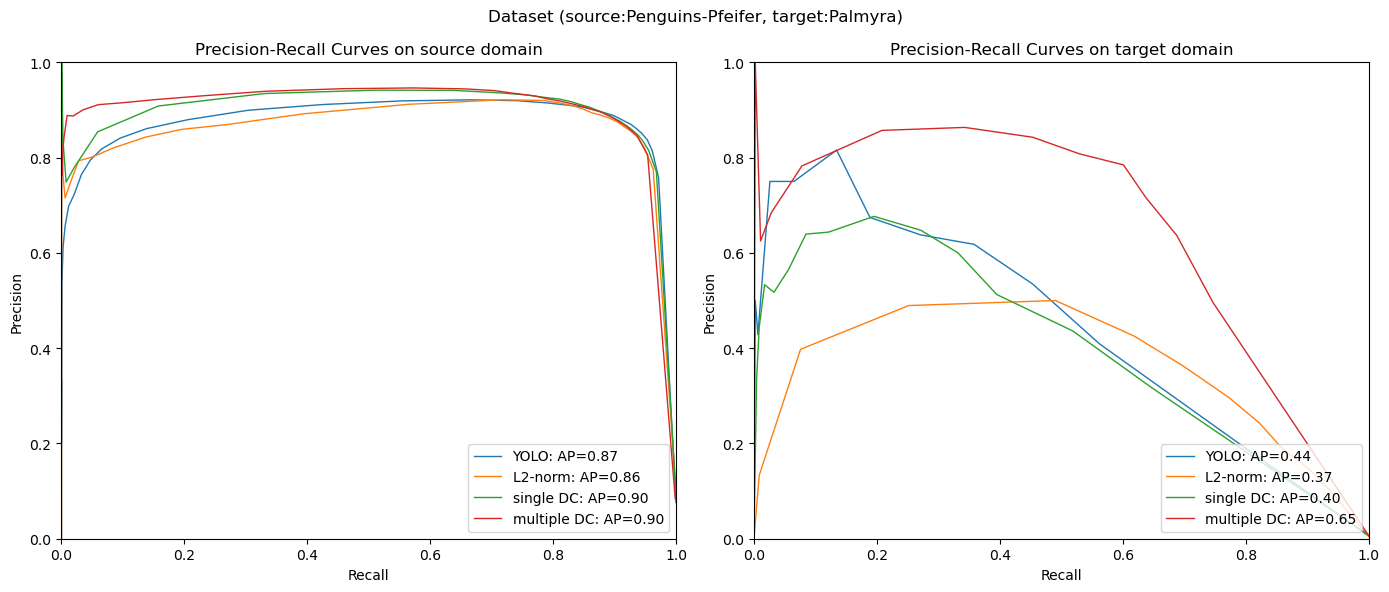

In [9]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect_multidatasets/'
DATASET = 'pepf_palmyra_10percentbkgd'   #'pe_palmyra_10percentbkgd'   #'pepf_palmyra_10percentbkgd' #'te_palm_10percent_background'

SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']

tasks = ['YOLO', 'featdist', 'DAN', 'multiDAN']
task_name = {'DAN': 'single DC', 'multiDAN': 'multiple DC', 'featdist': 'L2-norm', 'YOLO': 'YOLO'}

fig, ax = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
for task in tasks:

    MODEL_NAME = task + '_' + DATASET
    model_dir = os.path.join(models_folder, MODEL_NAME)
    results = os.path.join(model_dir, 'eval', EVAL_FILE)
    with open(results) as json_data:
        data = json.load(json_data)
        json_data.close()
    conf_thresholds = data['confidence_thresholds']
    FN = np.array(data['results_metrics']['FN'])
    FP = np.array(data['results_metrics']['FP'])
    TN = np.array(data['results_metrics']['TN'])
    TP = np.array(data['results_metrics']['TP'])
    print(data['datasets'])

    source_datasets_indices = [0, 1]
    target_datasets_indices = [2]

    source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
    source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
    target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
    target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)

    global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
    global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
                                        
    source_f1 = 2*(source_precision*source_recall)/(source_precision+source_recall+eps)
    target_f1 = 2*(target_precision*target_recall)/(target_precision+target_recall+eps)
    global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
    best_f1 = np.max(global_f1)
    best_f1_conf = conf_thresholds[np.argmax(global_f1)]

    # Compute Average Precision & plot PR curves
    source_AP = metrics.auc(y=source_precision, x=source_recall)
    target_AP = metrics.auc(y=target_precision, x=target_recall)

    ax[0].plot(source_recall, source_precision, linewidth=1, label=f'{task_name[task]}: AP={source_AP:.2f}')  # plot(recall, precision)
    ax[1].plot(target_recall, target_precision, linewidth=1, label=f'{task_name[task]}: AP={target_AP:.2f}')  # plot(recall, precision)


ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].legend(loc='lower right')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].legend(loc='lower right')
#ax.text(0.05, 0.95, f'Average Precision = {round(area, 2)}', transform=ax.transAxes, fontsize=14)
ax[0].set_title(f'Precision-Recall Curves on source domain')
ax[1].set_title(f'Precision-Recall Curves on target domain')

fig.suptitle("Dataset (source:Penguins-Pfeifer, target:Palmyra)")
fig.savefig(os.path.join(models_folder, DATASET + '_PRcurves_multi_architectures.jpg'), dpi=250)
plt.show()
plt.close(fig)


{'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_palmyra']}
{'source': ['global_birds_penguins', 'global_birds_pfeifer', 'global_birds_palmyra']}


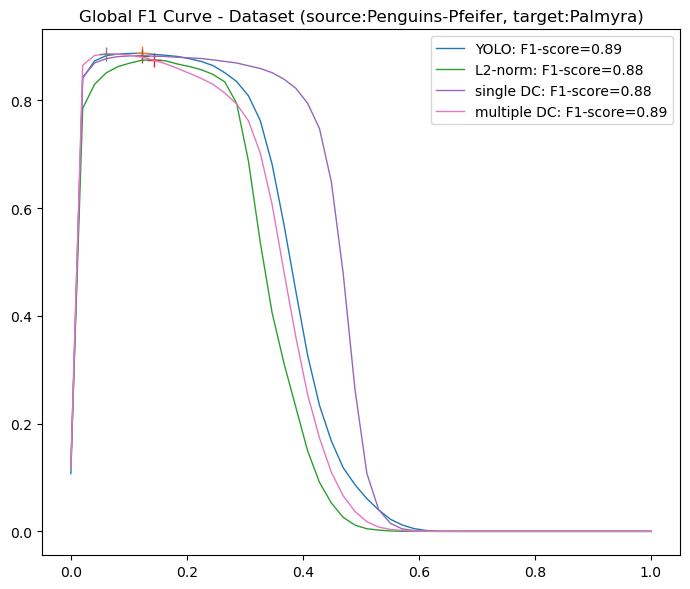

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6), tight_layout=True)
for task in tasks:

    MODEL_NAME = task + '_' + DATASET
    model_dir = os.path.join(models_folder, MODEL_NAME)
    results = os.path.join(model_dir, 'eval', EVAL_FILE)
    with open(results) as json_data:
        data = json.load(json_data)
        json_data.close()
    conf_thresholds = data['confidence_thresholds']
    FN = np.array(data['results_metrics']['FN'])
    FP = np.array(data['results_metrics']['FP'])
    TN = np.array(data['results_metrics']['TN'])
    TP = np.array(data['results_metrics']['TP'])
    print(data['datasets'])

    source_datasets_indices = [1]
    target_datasets_indices = [0]

    source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
    source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
    target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
    target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)

    global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
    global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
                                        
    source_f1 = 2*(source_precision*source_recall)/(source_precision+source_recall+eps)
    target_f1 = 2*(target_precision*target_recall)/(target_precision+target_recall+eps)
    global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
    best_f1 = np.max(global_f1)
    best_f1_conf = conf_thresholds[np.argmax(global_f1)]

    # Compute Average Precision & plot PR curves
    source_AP = metrics.auc(y=source_precision, x=source_recall)
    target_AP = metrics.auc(y=target_precision, x=target_recall)

    ax.plot(conf_thresholds, global_f1, linewidth=1, label=f'{task_name[task]}: F1-score={best_f1:.2f}')  # plot(recall, precision)
    ax.plot(best_f1_conf, best_f1, '+', linewidth=10, markersize=10)
    #ax.annotate(f'Maximal F1-score {best_f1:.2f}', xy=(best_f1_conf,best_f1))


ax.set_title(f'Global F1 Curve - Dataset (source:Penguins-Pfeifer, target:Palmyra)')
ax.legend(loc='upper right')
fig.savefig(os.path.join(models_folder, DATASET + '_F1curve_multi_architectures.jpg'), dpi=250)
plt.show()
plt.close(fig)



{'source': ['global_birds_penguins', 'terns_africa']}
{'source': ['global_birds_penguins', 'terns_africa']}
{'source': ['global_birds_penguins', 'terns_africa']}
{'source': ['global_birds_penguins', 'terns_africa']}


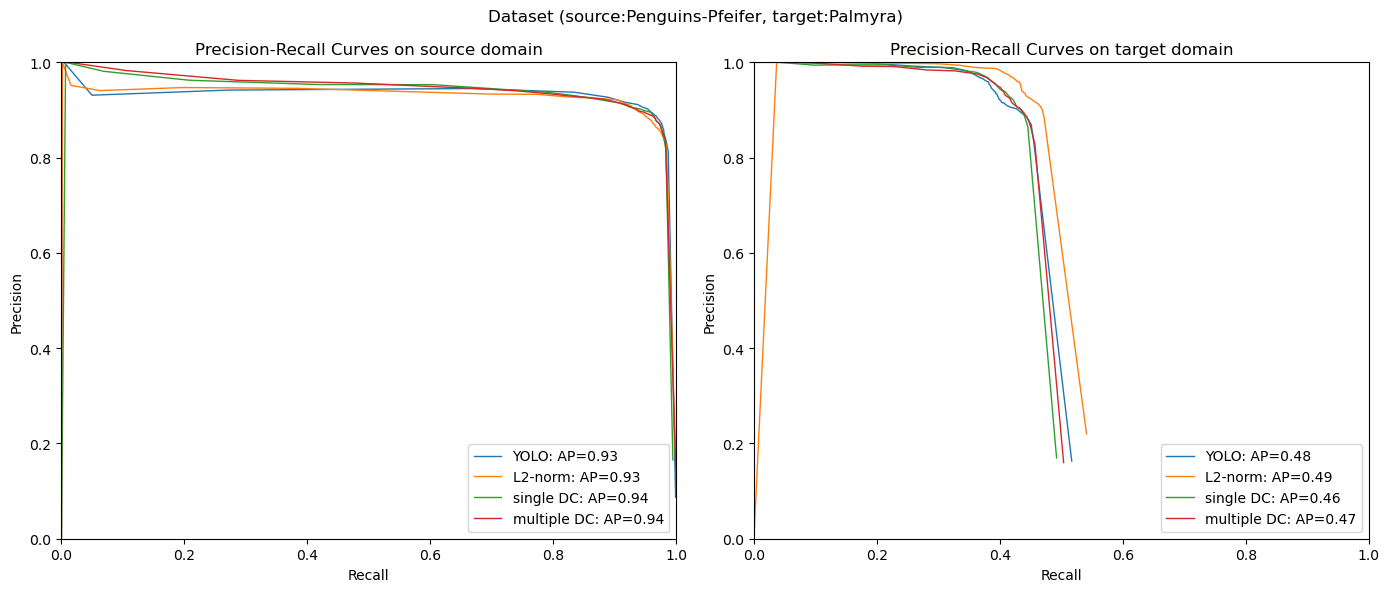

In [4]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect_multidatasets/'
DATASET = 'pe_te_10percent_background'   #'pe_palmyra_10percentbkgd'   #'pepf_palmyra_10percentbkgd' #'te_palm_10percent_background'

SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']

tasks = ['YOLO', 'featdist', 'DAN', 'multiDAN']
task_name = {'DAN': 'single DC', 'multiDAN': 'multiple DC', 'featdist': 'L2-norm', 'YOLO': 'YOLO'}

fig, ax = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
for task in tasks:

    MODEL_NAME = task + '_' + DATASET
    model_dir = os.path.join(models_folder, MODEL_NAME)
    results = os.path.join(model_dir, 'eval', EVAL_FILE)
    with open(results) as json_data:
        data = json.load(json_data)
        json_data.close()
    conf_thresholds = data['confidence_thresholds']
    FN = np.array(data['results_metrics']['FN'])
    FP = np.array(data['results_metrics']['FP'])
    TN = np.array(data['results_metrics']['TN'])
    TP = np.array(data['results_metrics']['TP'])
    print(data['datasets'])

    source_datasets_indices = [0]
    target_datasets_indices = [1]

    source_precision = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FP[source_datasets_indices, :], axis=0) + eps)
    source_recall = np.sum(TP[source_datasets_indices, :], axis=0) / (np.sum(TP[source_datasets_indices, :], axis=0) + np.sum(FN[source_datasets_indices, :], axis=0) + eps)
    target_precision = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FP[target_datasets_indices, :], axis=0) + eps)
    target_recall = np.sum(TP[target_datasets_indices, :], axis=0) / (np.sum(TP[target_datasets_indices, :], axis=0) + np.sum(FN[target_datasets_indices, :], axis=0) + eps)

    global_precision = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FP, axis=0) + eps)
    global_recall = np.sum(TP, axis=0) / (np.sum(TP, axis=0) + np.sum(FN, axis=0) + eps)
                                        
    source_f1 = 2*(source_precision*source_recall)/(source_precision+source_recall+eps)
    target_f1 = 2*(target_precision*target_recall)/(target_precision+target_recall+eps)
    global_f1 = 2*(global_precision*global_recall)/(global_precision+global_recall+eps)
    best_f1 = np.max(global_f1)
    best_f1_conf = conf_thresholds[np.argmax(global_f1)]

    # Compute Average Precision & plot PR curves
    source_AP = metrics.auc(y=source_precision, x=source_recall)
    target_AP = metrics.auc(y=target_precision, x=target_recall)

    ax[0].plot(source_recall, source_precision, linewidth=1, label=f'{task_name[task]}: AP={source_AP:.2f}')  # plot(recall, precision)
    ax[1].plot(target_recall, target_precision, linewidth=1, label=f'{task_name[task]}: AP={target_AP:.2f}')  # plot(recall, precision)


ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].legend(loc='lower right')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].legend(loc='lower right')
#ax.text(0.05, 0.95, f'Average Precision = {round(area, 2)}', transform=ax.transAxes, fontsize=14)
ax[0].set_title(f'Precision-Recall Curves on source domain')
ax[1].set_title(f'Precision-Recall Curves on target domain')

fig.suptitle("Dataset (source:Penguins-Pfeifer, target:Palmyra)")
fig.savefig(os.path.join(models_folder, DATASET + '_PRcurves_multi_architectures.jpg'), dpi=250)
plt.show()
plt.close(fig)


#### LOSSES

task= DAN
task= multiDAN
task= featdist
task= YOLO


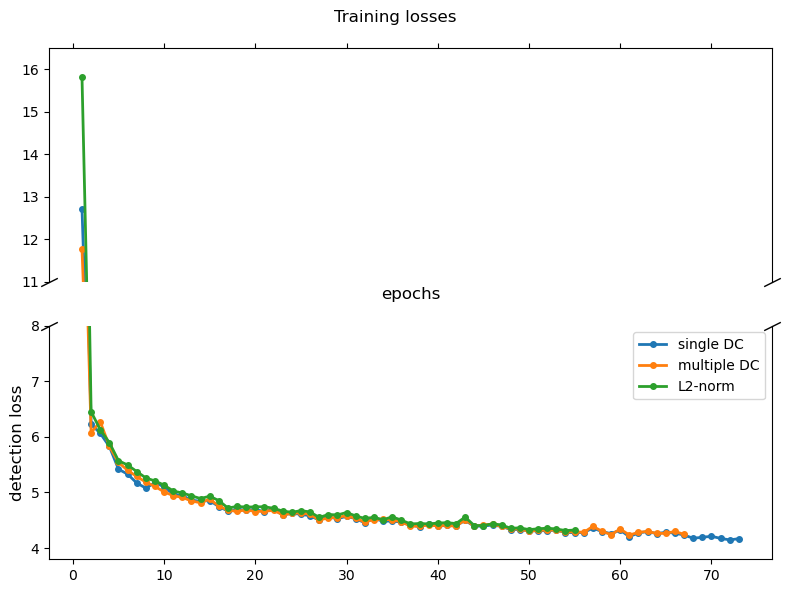

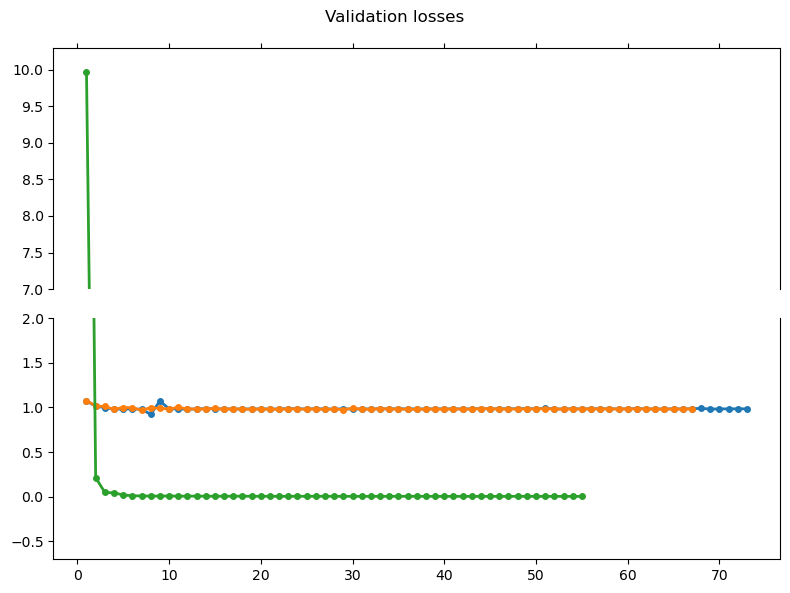

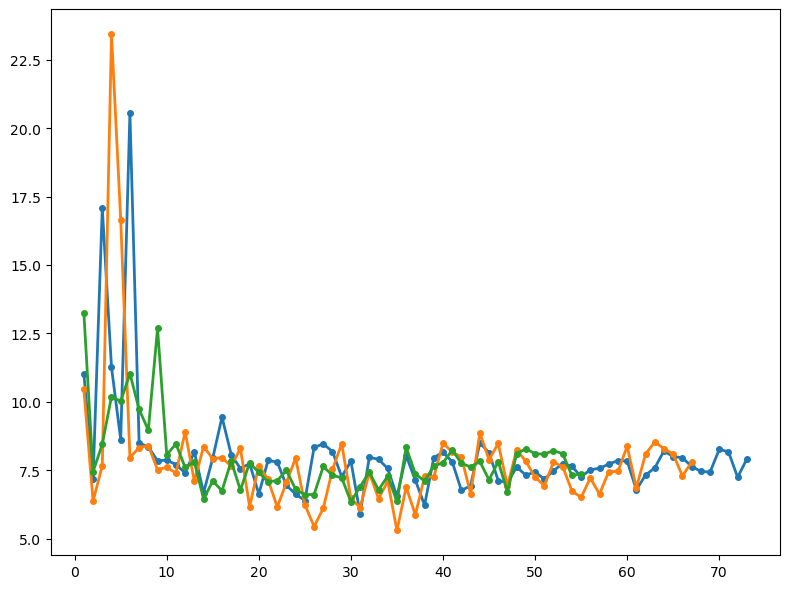

In [2]:
EVAL_FILE = "evaluation_results.json"

# Predictions parameters
eps = 1e-8

models_folder = '/home/eec42/BirdDetector/runs/detect_multidatasets/'
DATASET = 'pe_palmyra_10percentbkgd'   #'pe_palmyra_10percentbkgd'   #'pepf_palmyra_10percentbkgd' #'te_palm_10percent_background'

SUBDATASETS = DATASETS_MAPPING[DATASET]['datasets']

tasks = ['YOLO', 'featdist', 'DAN', 'multiDAN']
task_name = {'DAN': 'single DC', 'multiDAN': 'multiple DC', 'featdist': 'L2-norm', 'YOLO': 'YOLO'}

CSV_FILE = "results.csv"


models_folder = '/home/eec42/BirdDetector/runs/detect_multidatasets/'


plot_multiplearch_losses(task_name, models_folder, DATASET)

